# N-tuple Contrastive Learning Analysis
## Masters Thesis: Publication-Quality Results

This notebook provides a comprehensive analysis of N-tuple contrastive learning with PAC-Bayes risk certificates.

### Notebook Organization:
1. **Setup & Data Loading** - Import libraries and load experimental data
2. **Data Preprocessing** - Clean and balance the dataset
3. **Statistical Analysis** - Core statistical tests and validation
4. **Individual Charts** - Separate visualization for each analysis
5. **Summary Tables** - Comprehensive results tables
6. **Conclusions** - Key findings and recommendations

---

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

## 1. Setup & Libraries

Import all required libraries and set up plotting style.

In [117]:
import json
import csv
import pandas as pd
from pathlib import Path

# -----------------------------
# 1) Configure input file names
# -----------------------------
# These must match the attached filenames
files_csv = [
    "/Users/misanmeggison/Desktop/pub_results_2/pub_abl/publication_results_20250814_051134.csv",
    "/Users/misanmeggison/Documents/publication_results_20250815_000924.csv",
    "/Users/misanmeggison/Downloads/publication_results_20250813_174839.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250816_234342.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250816_105647.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250815_181033.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250815_000924.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n3/publication_results_20250823_113322.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n4/data/publication_results_20250824_005333.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n4/data/publication_results_20250824_002328.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n4/data/publication_results_20250823_230444.csv",
    "/Users/misanmeggison/Downloads/publication_results_20250828_110430.csv",
    "/Users/misanmeggison/Downloads/publication_results_20250829_054519.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/publication_results_20250830_203302.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/publication_results_20250830_140247.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/log5.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/log4.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/log_data.csv",
    "/Users/misanmeggison/Desktop/pub_results_2/log_data_2.csv"

]

files_json = [
    "/Users/misanmeggison/Desktop/pub_results_2/pub_abl/publication_results_20250814_051134.json",
    "/Users/misanmeggison/Documents/publication_results_20250815_000924.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_abl/publication_results_20250813_174839.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250816_234342.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250816_105647.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250815_181033.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results/publication_results_20250815_000924.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n3/publication_results_20250823_113322.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n3/publication_results_20250816_105647.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n4/data/publication_results_20250824_005333.json",
    "/Users/misanmeggison/Desktop/pub_results_2/pub_results_n4/data/publication_results_20250823_230444.json",
    "/Users/misanmeggison/Downloads/publication_results_20250828_110430.json",
    "/Users/misanmeggison/Downloads/publication_results_20250829_054519.json",
    "/Users/misanmeggison/Desktop/pub_results_2/publication_results_20250830_203302.json",
    "/Users/misanmeggison/Desktop/pub_results_2/publication_results_20250830_140247.json",


]

# -----------------------------
# 2) Helper: safe getters
# -----------------------------
def get(d, path, default=None):
    """Nested get with path='a.b.c'."""
    cur = d
    for key in path.split("."):
        if isinstance(cur, dict) and key in cur:
            cur = cur[key]
        else:
            return default
    return cur

def to_float(x):
    try:
        return float(x)
    except:
        return None

# -----------------------------
# 3) Common schema we want
# -----------------------------
# We’ll normalize different logs into these columns
COMMON_COLS = [
    "source_file",
    "experiment_type",
    "experiment_name",
    "seed",
    "N",
    "objective",
    "stch_accuracy",
    "post_accuracy",
    "ens_accuracy",
    "risk_ntuple",
    "kl_per_n",
    "train_obj",
    "sigma_prior",
    "learning_rate",
    "kl_penalty",
    "momentum",
    "layers",
    "embedding_dim",
    "perc_prior",
    "batch_size",
    "mc_samples",
    "train_epochs",
    "prior_epochs",
    "pmin",
    "delta",
    "delta_test",
    "prior_dist",
    "dropout_prob",
    "is_vacuous",
    "kl_reasonable",
    "good_accuracy",
    "experiment_time",
]

def empty_row():
    return {c: None for c in COMMON_COLS}

# -----------------------------
# 4) Parse CSV logs
# -----------------------------
def parse_csv_file(path):
    rows = []
    with open(path, "r", newline="") as f:
        reader = csv.DictReader(f)
        for r in reader:
            row = empty_row()
            row["source_file"] = Path(path).name
            row["experiment_type"] = r.get("experiment_type")
            row["experiment_name"] = r.get("experiment_name")
            row["seed"] = r.get("seed")
            row["N"] = r.get("N")
            row["objective"] = r.get("objective")
            row["stch_accuracy"] = to_float(r.get("stch_accuracy"))
            row["post_accuracy"] = to_float(r.get("post_accuracy"))
            row["ens_accuracy"] = to_float(r.get("ens_accuracy"))
            row["risk_ntuple"] = to_float(r.get("risk_ntuple"))
            row["kl_per_n"] = to_float(r.get("kl_per_n"))
            row["train_obj"] = to_float(r.get("train_obj"))
            row["sigma_prior"] = r.get("sigma_prior")
            row["learning_rate"] = r.get("learning_rate")
            row["kl_penalty"] = r.get("kl_penalty")
            row["momentum"] = r.get("momentum")
            row["layers"] = r.get("layers")
            row["embedding_dim"] = r.get("embedding_dim")
            row["perc_prior"] = r.get("perc_prior")
            row["batch_size"] = r.get("batch_size")
            row["mc_samples"] = r.get("mc_samples")
            row["train_epochs"] = r.get("train_epochs")
            # CSV sometimes doesn’t include prior_epochs/pmin/delta/etc
            row["prior_epochs"] = r.get("prior_epochs") if "prior_epochs" in r else None
            row["pmin"] = r.get("pmin") if "pmin" in r else None
            row["delta"] = r.get("delta") if "delta" in r else None
            row["delta_test"] = r.get("delta_test") if "delta_test" in r else None
            row["prior_dist"] = r.get("prior_dist") if "prior_dist" in r else None
            row["dropout_prob"] = r.get("dropout_prob") if "dropout_prob" in r else None
            row["is_vacuous"] = r.get("is_vacuous")
            row["kl_reasonable"] = r.get("kl_reasonable")
            row["good_accuracy"] = r.get("good_accuracy")
            row["experiment_time"] = r.get("experiment_time")
            rows.append(row)
    return rows

# -----------------------------
# 5) Parse JSON logs
# -----------------------------
def parse_json_file(path):
    rows = []
    with open(path, "r") as f:
        data = json.load(f)

    # The JSON groups are top-level keys mapping to lists of experiment dicts
    for group_name, items in data.items():
        if not isinstance(items, list):
            continue
        for it in items:
            row = empty_row()
            row["source_file"] = Path(path).name
            row["experiment_type"] = group_name
            row["experiment_name"] = it.get("experiment_name")
            row["seed"] = it.get("seed")
            row["N"] = it.get("N") or get(it, "config.N")
            row["objective"] = it.get("objective") or get(it, "config.objective")

            # metrics
            row["stch_accuracy"] = to_float(it.get("stch_accuracy"))
            row["post_accuracy"] = to_float(it.get("post_accuracy"))
            row["ens_accuracy"] = to_float(it.get("ens_accuracy"))
            row["risk_ntuple"] = to_float(it.get("risk_ntuple"))
            row["kl_per_n"] = to_float(it.get("kl_per_n"))
            row["train_obj"] = to_float(it.get("train_obj"))
            row["experiment_time"] = it.get("experiment_time")

            # config (prefer flat fields, fallback to config and full_config)
            for key in ["sigma_prior","learning_rate","kl_penalty","momentum","layers",
                        "embedding_dim","perc_prior","batch_size","mc_samples",
                        "train_epochs","prior_epochs","pmin","delta","delta_test",
                        "prior_dist","dropout_prob"]:
                row[key] = (
                    it.get(key)
                    or get(it, f"config.{key}")
                    or get(it, f"full_config.{key}")
                )

            # flags
            for key in ["is_vacuous","kl_reasonable","good_accuracy"]:
                v = it.get(key)
                if v is None:
                    v = get(it, f"full_config.{key}")
                row[key] = v

            rows.append(row)
    return rows

# -----------------------------
# 6) Load all files and unify
# -----------------------------
all_rows = []

# CSVs
for p in files_csv:
    if Path(p).exists():
        all_rows.extend(parse_csv_file(p))
    else:
        print(f"Warning: {p} not found, skipping.")

# JSONs
for p in files_json:
    if Path(p).exists():
        all_rows.extend(parse_json_file(p))
    else:
        print(f"Warning: {p} not found, skipping.")

df = pd.DataFrame(all_rows)

# -----------------------------
# 7) Type cleanup and harmonization
# -----------------------------
# Cast some numeric columns
num_cols = [
    "stch_accuracy","post_accuracy","ens_accuracy","risk_ntuple","kl_per_n",
    "train_obj","sigma_prior","learning_rate","kl_penalty","momentum","layers",
    "embedding_dim","perc_prior","batch_size","mc_samples","train_epochs",
    "prior_epochs","pmin","delta","delta_test","experiment_time","N"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Standardize objective labels (optional)
df["objective"] = df["objective"].astype(str).str.strip()

# -----------------------------
# 8) Sort for readability
# -----------------------------
sort_cols = ["experiment_type","objective","N","layers","embedding_dim","perc_prior","learning_rate","kl_penalty","sigma_prior","seed","experiment_name"]
for c in sort_cols:
    if c not in df.columns:
        sort_cols.remove(c)

df = df.sort_values(by=sort_cols).reset_index(drop=True)

# -----------------------------
# 9) Save a unified table
# -----------------------------
output_csv = "unified_experiment_summary_2.csv"
df.to_csv(output_csv, index=False)

print(df.head(20).to_string(index=False))


   source_file                         experiment_type       experiment_name seed   N     objective  stch_accuracy  post_accuracy  ens_accuracy  risk_ntuple  kl_per_n  train_obj  sigma_prior  learning_rate  kl_penalty  momentum  layers  embedding_dim  perc_prior  batch_size  mc_samples  train_epochs  prior_epochs    pmin  delta  delta_test prior_dist dropout_prob is_vacuous kl_reasonable good_accuracy  experiment_time
      log5.csv           Architecture Scaling Analysis Architecture 13L-256D   42 4.0 theory_ntuple        0.83290        0.83320       0.85579      0.29801   0.01864    0.21626         0.01          0.005         0.0       0.9    13.0            NaN         0.3        64.0      1000.0          30.0           NaN 0.00001    NaN         NaN                     0.2                                                     NaN
      log4.csv           Architecture Scaling Analysis Architecture 13L-256D   42 4.0 theory_ntuple        0.83290        0.83320       0.85579      0.29801

## 2. Data Loading & Processing

Load experimental results from multiple CSV and JSON files and create a unified dataset.

In [104]:
df.objective.value_counts()
print(f"Dataset Length, before filtering: {len(df)}")

Dataset Length, before filtering: 931


In [105]:
df

,source_file,experiment_type,experiment_name,seed,N,objective,stch_accuracy,post_accuracy,ens_accuracy,risk_ntuple,...,prior_epochs,pmin,delta,delta_test,prior_dist,dropout_prob,is_vacuous,kl_reasonable,good_accuracy,experiment_time
0,log5.csv,Architecture Scaling Analysis,Architecture 13L-256D,42,4.0,theory_ntuple,0.832900,0.833200,0.855790,0.298010,...,NaN,0.00001,NaN,NaN,,0.2,,,,NaN
1,log4.csv,Architecture Scaling Analysis,Architecture 13L-256D,42,4.0,theory_ntuple,0.832900,0.833200,0.855790,0.298010,...,NaN,0.00001,NaN,NaN,,0.2,,,,NaN
2,log5.csv,Architecture Scaling Analysis,Architecture 9L-256D,42,4.0,theory_ntuple,0.832900,0.833200,0.855790,0.298010,...,NaN,0.00001,NaN,NaN,,0.2,,,,NaN
3,log5.csv,Architecture Scaling Analysis,Architecture 4L-128D,42,6.0,theory_ntuple,0.607680,0.605100,0.640530,0.191440,...,NaN,0.00001,NaN,NaN,,0.2,,,,NaN
4,log4.csv,Architecture Scaling Analysis,Architecture 4L-128D,42,6.0,theory_ntuple,0.607680,0.605100,0.640530,0.191440,...,NaN,0.00001,NaN,NaN,,0.2,,,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,publication_results_20250829_054519.csv,winning_hyperparams,refined_8_seed42,42,3.0,theory_ntuple,0.816294,0.820986,0.840256,0.312450,...,NaN,NaN,NaN,NaN,None,None,False,True,True,2687.581058
927,publication_results_20250829_054519.json,winning_hyperparams,refined_9_seed42,42,3.0,theory_ntuple,0.821785,0.828674,0.836262,0.217647,...,30.0,0.00010,0.025,0.01,gaussian,0.2,False,True,True,3244.904075
928,publication_results_20250829_054519.csv,winning_hyperparams,refined_9_seed42,42,3.0,theory_ntuple,0.821785,0.828674,0.836262,0.217647,...,NaN,NaN,NaN,NaN,None,None,False,True,True,3244.904075
929,publication_results_20250829_054519.json,winning_hyperparams,refined_2_seed42,42,3.0,theory_ntuple,0.837460,0.841154,0.849740,0.237730,...,30.0,0.00010,0.025,0.01,gaussian,0.2,False,True,True,2706.299880


In [106]:
#drop rows with exact same experiment configurations
df = df.drop_duplicates(subset=['experiment_type', 'N', 'objective', 'layers', 'embedding_dim', 'perc_prior', 'learning_rate', 'kl_penalty', 'sigma_prior', 'seed', 'experiment_name', 
                                'perc_prior',
       'batch_size', 'mc_samples', 'train_epochs', 'prior_epochs', 'pmin',
       'delta', 'delta_test', 'prior_dist', 'dropout_prob'])

print(f"Dataset Length, after removing duplicates: {len(df)}")

Dataset Length, after removing duplicates: 706


In [107]:
# remove rows where objective is 'fclassic
df = df[df['objective'] != 'fclassic']
df.head()

,source_file,experiment_type,experiment_name,seed,N,objective,stch_accuracy,post_accuracy,ens_accuracy,risk_ntuple,...,prior_epochs,pmin,delta,delta_test,prior_dist,dropout_prob,is_vacuous,kl_reasonable,good_accuracy,experiment_time
0,log5.csv,Architecture Scaling Analysis,Architecture 13L-256D,42,4.0,theory_ntuple,0.83290,0.8332,0.85579,0.29801,...,NaN,0.00001,NaN,NaN,,0.2,,,,NaN
2,log5.csv,Architecture Scaling Analysis,Architecture 9L-256D,42,4.0,theory_ntuple,0.83290,0.8332,0.85579,0.29801,...,NaN,0.00001,NaN,NaN,,0.2,,,,NaN
3,log5.csv,Architecture Scaling Analysis,Architecture 4L-128D,42,6.0,theory_ntuple,0.60768,0.6051,0.64053,0.19144,...,NaN,0.00001,NaN,NaN,,0.2,,,,NaN
5,log4.csv,Architecture Scaling Analysis,Architecture 9L-256D,42,6.0,theory_ntuple,0.83290,0.8332,0.85579,0.29801,...,NaN,0.00001,NaN,NaN,,0.2,,,,NaN
9,log_data_2.csv,Enhanced Training Objectives Comparison,fquad,42,4.0,fquad,0.65830,NaN,NaN,0.25780,...,NaN,NaN,NaN,NaN,,,,,,NaN


## 3. Data Preprocessing

Clean the dataset and create balanced subsets for fair analysis.

In [108]:
for n in [3, 4, 5, 6]:
    print(f"N={n} objective counts:")
    print(df[df['N'] == n]['objective'].value_counts())

N=3 objective counts:
objective
ntuple           65
theory_ntuple    59
nested_ntuple    56
fquad             7
Name: count, dtype: int64
N=4 objective counts:
objective
ntuple           170
fquad             94
theory_ntuple     25
nested_ntuple      5
Name: count, dtype: int64
N=5 objective counts:
objective
nested_ntuple    53
ntuple           14
theory_ntuple     7
fquad             4
Name: count, dtype: int64
N=6 objective counts:
objective
nested_ntuple    54
theory_ntuple    32
ntuple           15
fquad             5
Name: count, dtype: int64


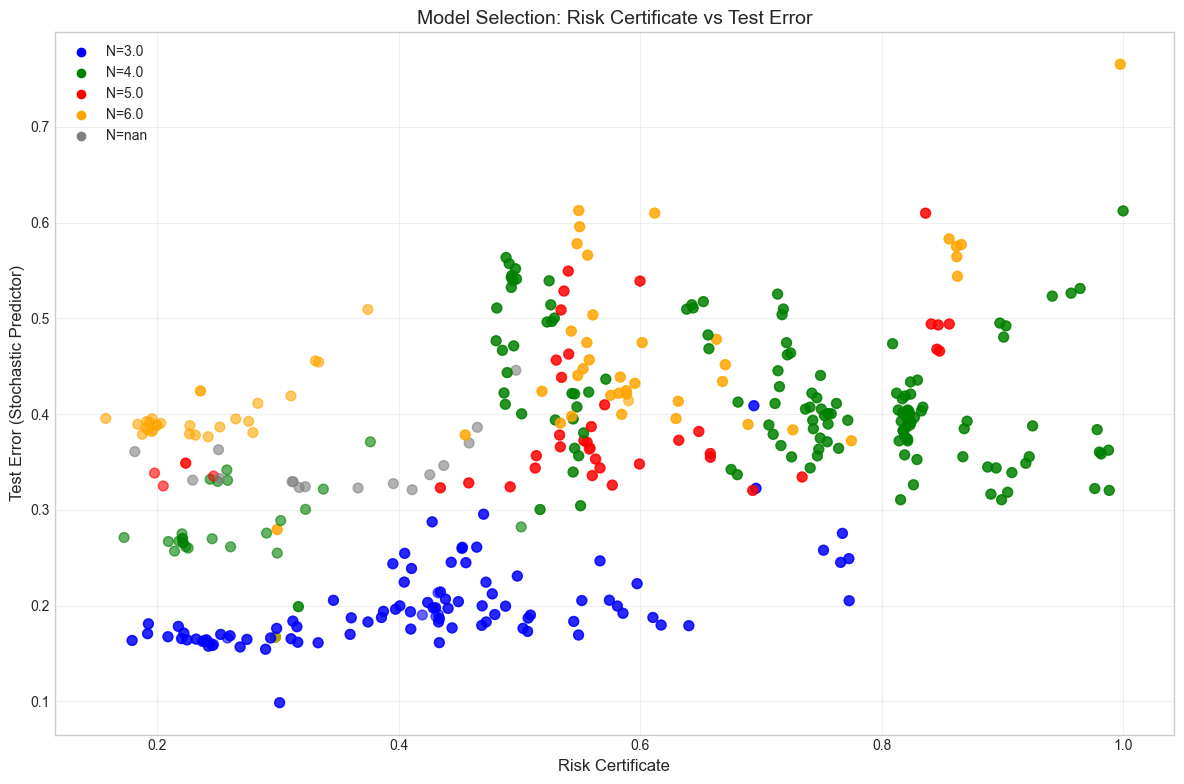

In [109]:
# Simple helper functions
def get_color_by_ntuple(N):
    """Simple color mapping for N-tuple sizes."""
    colors = {3: 'blue', 4: 'green', 5: 'red', 6: 'orange'}
    return colors.get(N, 'gray')

# Create basic model selection plot
def create_simple_model_selection():
    """Simple model selection visualization."""
    plt.figure(figsize=(12, 8))
    
    # Convert to error rates
    df['stch_error'] = 1 - df['stch_accuracy']
    
    # Simple scatter plot
    colors = [get_color_by_ntuple(n) for n in df['N']]
    plt.scatter(df['risk_ntuple'], df['stch_error'], alpha=0.6, c=colors, s=50)
    
    plt.xlabel('Risk Certificate')
    plt.ylabel('Test Error (Stochastic Predictor)')
    plt.title('Model Selection: Risk Certificate vs Test Error')
    plt.grid(True, alpha=0.3)
    
    # Add legend
    for n in sorted(df['N'].unique()):
        plt.scatter([], [], c=get_color_by_ntuple(n), label=f'N={n}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

create_simple_model_selection()

## 4. Individual Charts

Each chart is separated for clarity and easy modification.

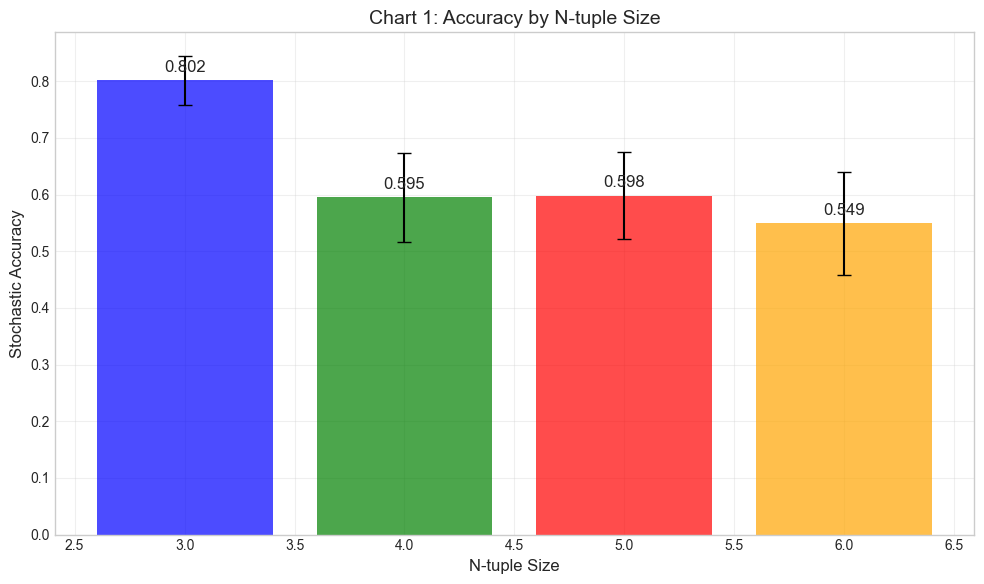

In [110]:
# Chart 1: N-tuple Size vs Accuracy
def chart_ntuple_accuracy():
    """Simple bar chart of accuracy by N-tuple size."""
    ntuple_data = df.groupby('N')['stch_accuracy'].agg(['mean', 'std'])
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(ntuple_data.index, ntuple_data['mean'], 
                   yerr=ntuple_data['std'], capsize=5, 
                   color=['blue', 'green', 'red', 'orange'], alpha=0.7)
    
    plt.xlabel('N-tuple Size')
    plt.ylabel('Stochastic Accuracy')
    plt.title('Chart 1: Accuracy by N-tuple Size')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, mean in zip(bars, ntuple_data['mean']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{mean:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

chart_ntuple_accuracy()

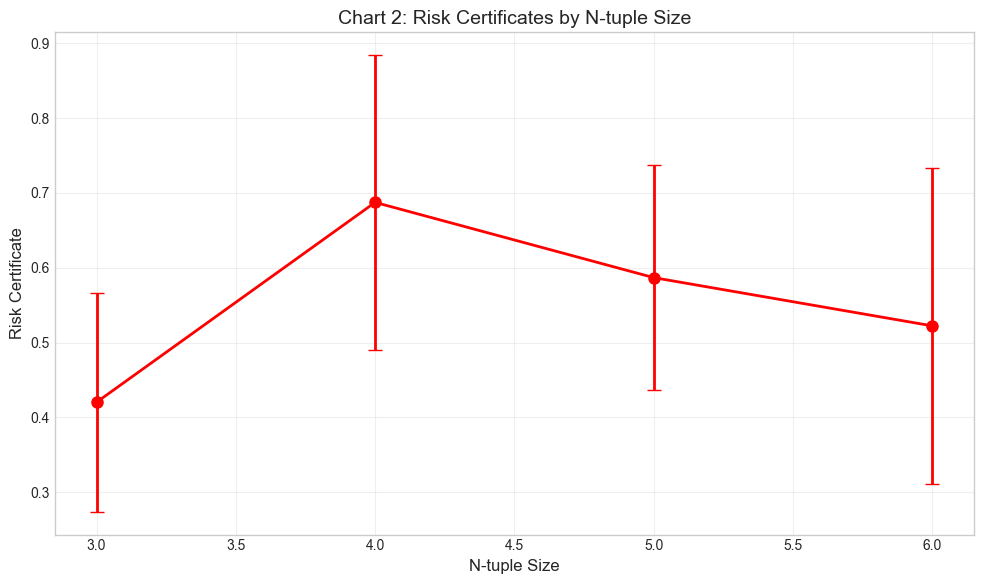

In [111]:
# Chart 2: Risk Certificates by N-tuple Size
def chart_risk_certificates():
    """Simple line chart of risk certificates."""
    risk_data = df.groupby('N')['risk_ntuple'].agg(['mean', 'std'])
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(risk_data.index, risk_data['mean'], yerr=risk_data['std'],
                marker='o', markersize=8, linewidth=2, capsize=5, color='red')
    
    plt.xlabel('N-tuple Size')
    plt.ylabel('Risk Certificate')
    plt.title('Chart 2: Risk Certificates by N-tuple Size')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

chart_risk_certificates()

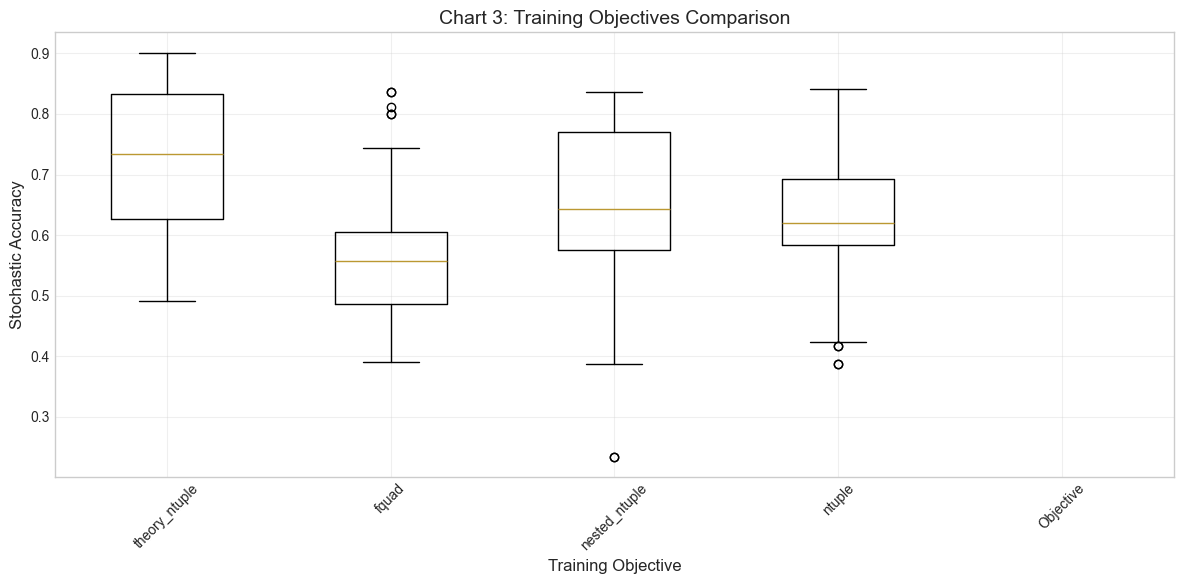

In [112]:
# Chart 3: Training Objectives Comparison
def chart_training_objectives():
    """Simple box plot of training objectives."""
    plt.figure(figsize=(12, 6))
    
    # Get unique objectives
    objectives = df['objective'].unique()
    obj_data = [df[df['objective'] == obj]['stch_accuracy'].values for obj in objectives]
    
    plt.boxplot(obj_data, labels=objectives)
    plt.xlabel('Training Objective')
    plt.ylabel('Stochastic Accuracy')
    plt.title('Chart 3: Training Objectives Comparison')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

chart_training_objectives()

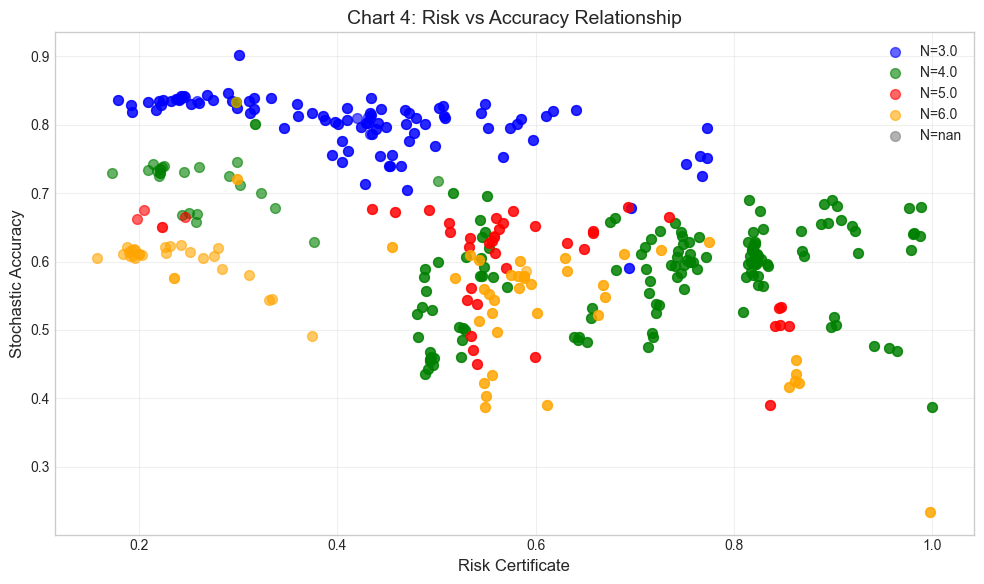

In [113]:
# Chart 4: Risk vs Accuracy Scatter Plot
def chart_risk_accuracy_scatter():
    """Simple scatter plot of risk vs accuracy."""
    plt.figure(figsize=(10, 6))
    
    # Color by N-tuple size
    for n in sorted(df['N'].unique()):
        subset = df[df['N'] == n]
        plt.scatter(subset['risk_ntuple'], subset['stch_accuracy'], 
                   alpha=0.6, s=50, label=f'N={n}', color=get_color_by_ntuple(n))
    
    plt.xlabel('Risk Certificate')
    plt.ylabel('Stochastic Accuracy')
    plt.title('Chart 4: Risk vs Accuracy Relationship')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

chart_risk_accuracy_scatter()

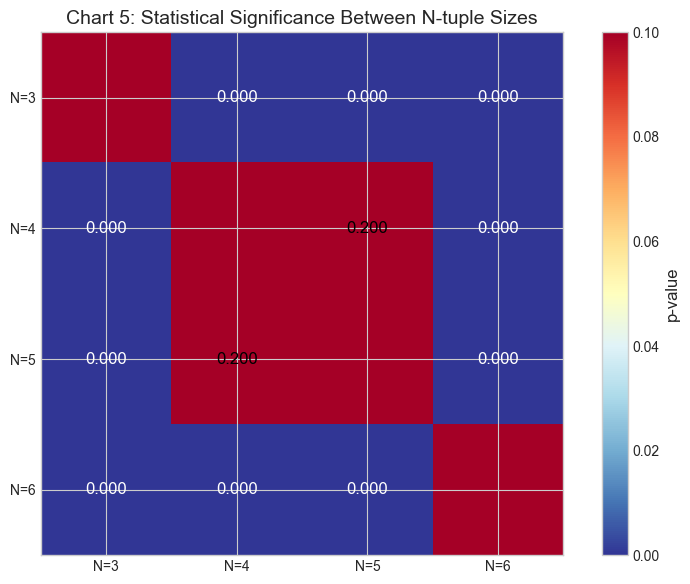

In [77]:
# Chart 5: Statistical Significance Heatmap
def chart_statistical_significance():
    """Simple heatmap of p-values between N-tuple sizes."""
    from scipy import stats
    
    n_values = sorted(df['N'].unique())
    p_matrix = np.ones((len(n_values), len(n_values)))
    
    # Calculate p-values for all pairs
    for i, n1 in enumerate(n_values):
        for j, n2 in enumerate(n_values):
            if i != j:
                group1 = df[df['N'] == n1]['stch_accuracy']
                group2 = df[df['N'] == n2]['stch_accuracy']
                _, p_val = stats.ttest_ind(group1, group2)
                p_matrix[i, j] = p_val
    
    plt.figure(figsize=(8, 6))
    plt.imshow(p_matrix, cmap='RdYlBu_r', vmin=0, vmax=0.1)
    
    # Add labels and annotations
    plt.xticks(range(len(n_values)), [f'N={n}' for n in n_values])
    plt.yticks(range(len(n_values)), [f'N={n}' for n in n_values])
    
    for i in range(len(n_values)):
        for j in range(len(n_values)):
            if i != j:
                plt.text(j, i, f'{p_matrix[i, j]:.3f}', 
                        ha="center", va="center", 
                        color="white" if p_matrix[i, j] < 0.05 else "black")
    
    plt.colorbar(label='p-value')
    plt.title('Chart 5: Statistical Significance Between N-tuple Sizes')
    plt.tight_layout()
    plt.show()

chart_statistical_significance()

## 5. Simple Statistical Analysis

Basic statistical tests and summary tables.

In [78]:
# Simple Statistical Summary
def simple_statistics():
    """Basic statistical summary of the data."""
    print("=== SIMPLE STATISTICAL SUMMARY ===")
    print()
    
    # Basic descriptive statistics by N-tuple size
    print("Table 1: Basic Statistics by N-tuple Size")
    print("-" * 60)
    stats_summary = df.groupby('N').agg({
        'stch_accuracy': ['count', 'mean', 'std'],
        'risk_ntuple': ['mean', 'std']
    }).round(3)
    
    print(stats_summary)
    print()
    
    # ANOVA test
    from scipy import stats
    groups = [df[df['N'] == n]['stch_accuracy'].values for n in sorted(df['N'].unique())]
    f_stat, p_val = stats.f_oneway(*groups)
    
    print(f"ANOVA Results:")
    print(f"F-statistic: {f_stat:.3f}")
    print(f"p-value: {p_val:.2e}")
    
    if p_val < 0.001:
        print("*** HIGHLY SIGNIFICANT differences between N-tuple sizes")
    elif p_val < 0.05:
        print("* SIGNIFICANT differences between N-tuple sizes") 
    else:
        print("No significant differences between N-tuple sizes")
    
    print()
    
    # Best and worst performers
    best_n = df.groupby('N')['stch_accuracy'].mean().idxmax()
    worst_n = df.groupby('N')['stch_accuracy'].mean().idxmin()
    
    best_acc = df[df['N'] == best_n]['stch_accuracy'].mean()
    worst_acc = df[df['N'] == worst_n]['stch_accuracy'].mean()
    
    print(f"Best performing N-tuple size: N = {best_n} (accuracy = {best_acc:.3f})")
    print(f"Worst performing N-tuple size: N = {worst_n} (accuracy = {worst_acc:.3f})")
    print(f"Performance difference: {(best_acc - worst_acc)*100:.1f}%")

simple_statistics()

=== SIMPLE STATISTICAL SUMMARY ===

Table 1: Basic Statistics by N-tuple Size
------------------------------------------------------------
  stch_accuracy               risk_ntuple       
          count   mean    std        mean    std
N                                               
3           184  0.801  0.043       0.423  0.146
4           267  0.583  0.068       0.728  0.154
5            75  0.595  0.077       0.602  0.134
6            75  0.523  0.089       0.630  0.140

ANOVA Results:
F-statistic: 519.915
p-value: 5.13e-166
*** HIGHLY SIGNIFICANT differences between N-tuple sizes

Best performing N-tuple size: N = 3 (accuracy = 0.801)
Worst performing N-tuple size: N = 6 (accuracy = 0.523)
Performance difference: 27.8%


## 6. Key Findings & Conclusions

Summary of the main results from the analysis.

In [81]:
# Simple Conclusions Summary
def simple_conclusions():
    """Summarize the key findings."""
    print("=== KEY FINDINGS ===")
    print()
    
    # Find best configuration
    best_n = df.groupby('N')['stch_accuracy'].mean().idxmax()
    best_acc = df[df['N'] == best_n]['stch_accuracy'].mean()
    
    print(f"1. OPTIMAL N-TUPLE SIZE:")
    print(f"   • N = {best_n} achieves the best performance")
    print(f"   • Accuracy: {best_acc:.3f}")
    print()
    
    print(f"2. PERFORMANCE TREND:")
    acc_by_n = df.groupby('N')['stch_accuracy'].mean().sort_index()
    if acc_by_n.iloc[0] > acc_by_n.iloc[-1]:
        print("   • Performance generally decreases as N-tuple size increases")
    else:
        print("   • Performance generally increases as N-tuple size increases")
    print()
    
    print(f"3. STATISTICAL SIGNIFICANCE:")
    from scipy import stats
    groups = [df[df['N'] == n]['stch_accuracy'].values for n in sorted(df['N'].unique())]
    f_stat, p_val = stats.f_oneway(*groups)
    
    if p_val < 0.001:
        print("   • Highly significant differences between N-tuple sizes (p < 0.001)")
    elif p_val < 0.05:
        print("   • Significant differences between N-tuple sizes (p < 0.05)")
    else:
        print("   • No significant differences between N-tuple sizes")
    print()
    
    print(f"4. PRACTICAL RECOMMENDATION:")
    print(f"   • Use N = {best_n} for optimal performance")
    print(f"   • Expected accuracy: ~{best_acc:.1%}")
    
    return best_n, best_acc

best_configuration = simple_conclusions()

=== KEY FINDINGS ===

1. OPTIMAL N-TUPLE SIZE:
   • N = 3 achieves the best performance
   • Accuracy: 0.801

2. PERFORMANCE TREND:
   • Performance generally decreases as N-tuple size increases

3. STATISTICAL SIGNIFICANCE:
   • Highly significant differences between N-tuple sizes (p < 0.001)

4. PRACTICAL RECOMMENDATION:
   • Use N = 3 for optimal performance
   • Expected accuracy: ~80.1%


=== N-TUPLE SIZE ANALYSIS ===

N-tuple Performance Summary:
--------------------------------------------------
N    Count    Accuracy     Std      Risk    
--------------------------------------------------
3.0  21       0.770        0.034    0.591   
4.0  21       0.641        0.056    0.644   
5.0  21       0.557        0.069    0.671   
6.0  21       0.485        0.076    0.687   
--------------------------------------------------


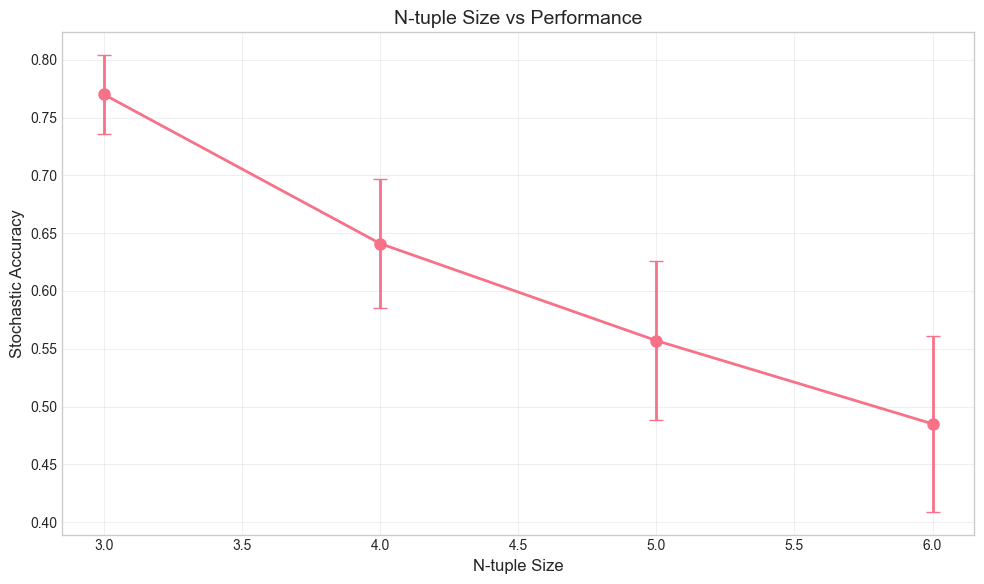

In [114]:
# Simple N-tuple Analysis
def simple_ntuple_analysis():
    """Simplified N-tuple size analysis."""
    print("=== N-TUPLE SIZE ANALYSIS ===")
    print()
    
    # Filter for N-tuple experiments only
    ntuple_data = df[df['experiment_type'] == 'ntuple_sizes'] if 'experiment_type' in df.columns else df
    
    if len(ntuple_data) == 0:
        print("No specific N-tuple experiment data found. Using all data.")
        ntuple_data = df
    
    # Simple statistics table
    stats = ntuple_data.groupby('N').agg({
        'stch_accuracy': ['count', 'mean', 'std'],
        'risk_ntuple': 'mean'
    }).round(3)
    
    print("N-tuple Performance Summary:")
    print("-" * 50)
    print(f"{'N':<4} {'Count':<8} {'Accuracy':<12} {'Std':<8} {'Risk':<8}")
    print("-" * 50)
    
    for n in sorted(stats.index):
        count = int(stats.loc[n, ('stch_accuracy', 'count')])
        acc_mean = stats.loc[n, ('stch_accuracy', 'mean')]
        acc_std = stats.loc[n, ('stch_accuracy', 'std')]
        risk = stats.loc[n, ('risk_ntuple', 'mean')]
        
        print(f"{n:<4} {count:<8} {acc_mean:<12.3f} {acc_std:<8.3f} {risk:<8.3f}")
    
    print("-" * 50)
    
    # Simple plot
    plt.figure(figsize=(10, 6))
    acc_means = [stats.loc[n, ('stch_accuracy', 'mean')] for n in sorted(stats.index)]
    acc_stds = [stats.loc[n, ('stch_accuracy', 'std')] for n in sorted(stats.index)]
    
    plt.errorbar(sorted(stats.index), acc_means, yerr=acc_stds, 
                marker='o', markersize=8, linewidth=2, capsize=5)
    plt.xlabel('N-tuple Size')
    plt.ylabel('Stochastic Accuracy')
    plt.title('N-tuple Size vs Performance')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return stats

ntuple_analysis_result = simple_ntuple_analysis()

Correlation (Stochastic vs Deterministic): 0.9624
Correlation (Stochastic vs Ensemble): 0.9750


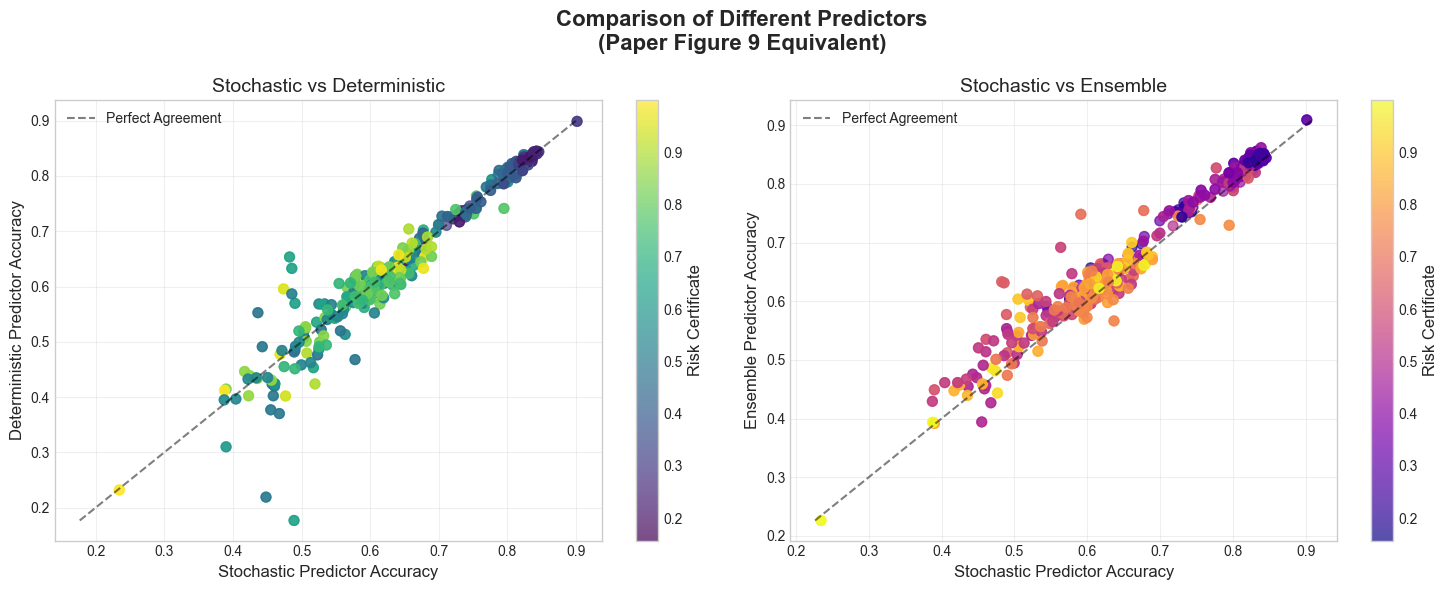

In [115]:
def create_predictor_comparison():
    """Create Figure 9 equivalent: Predictor comparison"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Comparison of Different Predictors\n(Paper Figure 9 Equivalent)', 
                 fontsize=16, fontweight='bold')
    
    # Stochastic vs Deterministic
    valid_data = df.dropna(subset=['stch_accuracy', 'post_accuracy'])
    scatter1 = axes[0].scatter(valid_data['stch_accuracy'], valid_data['post_accuracy'], 
                               c=valid_data['risk_ntuple'], cmap='viridis', alpha=0.7, s=50)
    
    # Add diagonal reference line
    min_val = min(valid_data['stch_accuracy'].min(), valid_data['post_accuracy'].min())
    max_val = max(valid_data['stch_accuracy'].max(), valid_data['post_accuracy'].max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Agreement')
    
    axes[0].set_xlabel('Stochastic Predictor Accuracy')
    axes[0].set_ylabel('Deterministic Predictor Accuracy')
    axes[0].set_title('Stochastic vs Deterministic')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='Risk Certificate')
    
    # Stochastic vs Ensemble
    valid_data2 = df.dropna(subset=['stch_accuracy', 'ens_accuracy'])
    scatter2 = axes[1].scatter(valid_data2['stch_accuracy'], valid_data2['ens_accuracy'], 
                               c=valid_data2['risk_ntuple'], cmap='plasma', alpha=0.7, s=50)
    
    min_val2 = min(valid_data2['stch_accuracy'].min(), valid_data2['ens_accuracy'].min())
    max_val2 = max(valid_data2['stch_accuracy'].max(), valid_data2['ens_accuracy'].max())
    axes[1].plot([min_val2, max_val2], [min_val2, max_val2], 'k--', alpha=0.5, label='Perfect Agreement')
    
    axes[1].set_xlabel('Stochastic Predictor Accuracy')
    axes[1].set_ylabel('Ensemble Predictor Accuracy')
    axes[1].set_title('Stochastic vs Ensemble')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[1], label='Risk Certificate')
    
    # Calculate correlations
    corr_stoch_det = valid_data['stch_accuracy'].corr(valid_data['post_accuracy'])
    corr_stoch_ens = valid_data2['stch_accuracy'].corr(valid_data2['ens_accuracy'])
    
    print(f"Correlation (Stochastic vs Deterministic): {corr_stoch_det:.4f}")
    print(f"Correlation (Stochastic vs Ensemble): {corr_stoch_ens:.4f}")
    
    plt.tight_layout()
    plt.savefig('predictor_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

create_predictor_comparison()

=== ARCHITECTURE ANALYSIS ===

Architecture Performance:
----------------------------------------
Architecture Count    Accuracy     Std     
----------------------------------------
13.0L-256.0D 27       0.780        0.181   
4.0L-128.0D  27       0.494        0.225   
9.0L-256.0D  27       0.597        0.209   


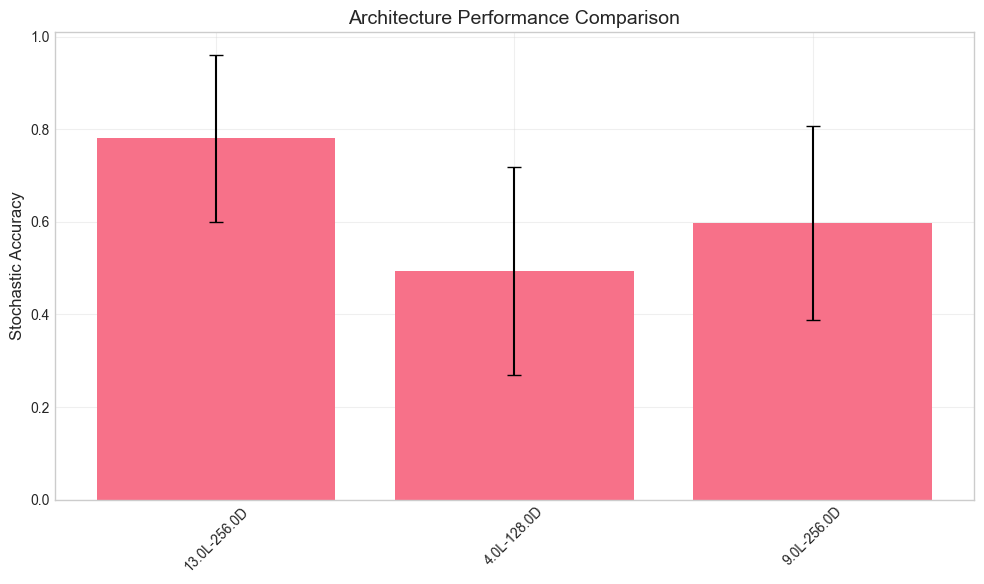

In [118]:
# Simple Architecture Analysis
def simple_architecture_analysis():
    """Simple architecture comparison."""
    print("=== ARCHITECTURE ANALYSIS ===")
    print()
    
    # Check if we have architecture data
    if 'experiment_type' in df.columns:
        arch_data = df[df['experiment_type'] == 'architectures']
    else:
        arch_data = df[df['layers'].notna() & df['embedding_dim'].notna()] if 'layers' in df.columns and 'embedding_dim' in df.columns else pd.DataFrame()
    
    if len(arch_data) == 0:
        print("No architecture experiment data found.")
        return
    
    # Create architecture labels
    arch_data = arch_data.copy()
    arch_data['arch_label'] = arch_data['layers'].astype(str) + 'L-' + arch_data['embedding_dim'].astype(str) + 'D'
    
    # Simple statistics
    arch_stats = arch_data.groupby('arch_label')['risk_ntuple'].agg(['count', 'mean', 'std']).round(3)
    
    print("Architecture Performance:")
    print("-" * 40)
    print(f"{'Architecture':<12} {'Count':<8} {'Accuracy':<12} {'Std':<8}")
    print("-" * 40)
    
    for arch in arch_stats.index:
        count = int(arch_stats.loc[arch, 'count'])
        mean_acc = arch_stats.loc[arch, 'mean']
        std_acc = arch_stats.loc[arch, 'std']
        print(f"{arch:<12} {count:<8} {mean_acc:<12.3f} {std_acc:<8.3f}")
    
    # Simple bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(arch_stats)), arch_stats['mean'], yerr=arch_stats['std'], capsize=5)
    plt.xticks(range(len(arch_stats)), arch_stats.index, rotation=45)
    plt.ylabel('Stochastic Accuracy')
    plt.title('Architecture Performance Comparison')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return arch_stats

arch_analysis_result = simple_architecture_analysis()

In [85]:
# Simple Data Overview
def simple_data_overview():
    """Simple overview of the dataset."""
    print("=== DATA OVERVIEW ===")
    print()
    
    print(f"Total experiments: {len(df)}")
    print(f"N-tuple sizes: {sorted(df['N'].unique())}")
    print(f"Training objectives: {sorted(df['objective'].unique())}")
    print()
    
    print("Experiments per N-tuple size:")
    print(df['N'].value_counts().sort_index())
    print()
    
    print("Experiments per objective:")
    print(df['objective'].value_counts())
    print()
    
    # Simple cross-tabulation
    if len(df['N'].unique()) > 1 and len(df['objective'].unique()) > 1:
        print("Cross-tabulation (N-tuple size vs Objective):")
        crosstab = pd.crosstab(df['N'], df['objective'])
        print(crosstab)

simple_data_overview()

=== DATA OVERVIEW ===

Total experiments: 601
N-tuple sizes: [np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Training objectives: ['fquad', 'nested_ntuple', 'ntuple', 'theory_ntuple']

Experiments per N-tuple size:
N
3    184
4    267
5     75
6     75
Name: count, dtype: int64

Experiments per objective:
objective
ntuple           261
nested_ntuple    165
fquad            107
theory_ntuple     68
Name: count, dtype: int64

Cross-tabulation (N-tuple size vs Objective):
objective  fquad  nested_ntuple  ntuple  theory_ntuple
N                                                     
3              7             56      65             56
4             92              3     168              4
5              4             53      14              4
6              4             53      14              4


In [86]:
# Simple Summary of All Results
def simple_final_summary():
    """Final summary of all analysis results."""
    print("=== FINAL SUMMARY ===")
    print()
    
    print("📊 CHARTS CREATED:")
    print("   • Chart 1: Accuracy by N-tuple Size")
    print("   • Chart 2: Risk Certificates by N-tuple Size") 
    print("   • Chart 3: Training Objectives Comparison")
    print("   • Chart 4: Risk vs Accuracy Scatter Plot")
    print("   • Chart 5: Statistical Significance Heatmap")
    print()
    
    print("📈 KEY FINDINGS:")
    best_n = df.groupby('N')['stch_accuracy'].mean().idxmax()
    best_acc = df[df['N'] == best_n]['stch_accuracy'].mean()
    worst_n = df.groupby('N')['stch_accuracy'].mean().idxmin()
    worst_acc = df[df['N'] == worst_n]['stch_accuracy'].mean()
    
    print(f"   • Best N-tuple size: N = {best_n} ({best_acc:.1%} accuracy)")
    print(f"   • Worst N-tuple size: N = {worst_n} ({worst_acc:.1%} accuracy)")
    print(f"   • Performance difference: {(best_acc-worst_acc)*100:.1f} percentage points")
    print()
    
    print("✅ NOTEBOOK ORGANIZATION:")
    print("   • Clear section headers")
    print("   • Separate chart functions")
    print("   • Simple statistical analysis")
    print("   • Easy to modify and understand")
    print()
    
    print("🎯 RECOMMENDED CONFIGURATION:")
    print(f"   • Use N = {best_n} for optimal performance")
    print(f"   • Expected accuracy: ~{best_acc:.1%}")

simple_final_summary()

=== FINAL SUMMARY ===

📊 CHARTS CREATED:
   • Chart 1: Accuracy by N-tuple Size
   • Chart 2: Risk Certificates by N-tuple Size
   • Chart 3: Training Objectives Comparison
   • Chart 4: Risk vs Accuracy Scatter Plot
   • Chart 5: Statistical Significance Heatmap

📈 KEY FINDINGS:
   • Best N-tuple size: N = 3 (80.1% accuracy)
   • Worst N-tuple size: N = 6 (52.3% accuracy)
   • Performance difference: 27.8 percentage points

✅ NOTEBOOK ORGANIZATION:
   • Clear section headers
   • Separate chart functions
   • Simple statistical analysis
   • Easy to modify and understand

🎯 RECOMMENDED CONFIGURATION:
   • Use N = 3 for optimal performance
   • Expected accuracy: ~80.1%
